# 🏠 House Price Prediction - Model Training Pipeline

## VietAI - Foundations of Machine Learning Final Project

**Mục tiêu:**
- Data Validation & Preprocessing
- Feature Engineering  
- Huấn luyện nhiều mô hình (Linear Regression, Ridge, Lasso, Random Forest, XGBoost)
- Đánh giá và so sánh mô hình
- Lưu mô hình tốt nhất để triển khai

**Bonus:** Deep Learning với Neural Network


In [24]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
import sys
import joblib

# Add src to path
sys.path.append('..')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# Create directories
os.makedirs('../models', exist_ok=True)
os.makedirs('../reports', exist_ok=True)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 1. Load và Validate Data


In [25]:
# Load data
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

print(f"✅ Training data: {train_df.shape}")
print(f"✅ Test data: {test_df.shape}")

# Target variable
TARGET = 'SalePrice'

# Separate features and target
X = train_df.drop([TARGET, 'Id'], axis=1)
y = train_df[TARGET]

print(f"\n📊 Features shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")


✅ Training data: (1460, 81)
✅ Test data: (1459, 80)

📊 Features shape: (1460, 79)
🎯 Target shape: (1460,)


In [26]:
# Data Validation - Schema Check
from src.data_validation import HousePriceSchema, check_data_quality

# Initialize schema
schema = HousePriceSchema()

# Validate data
is_valid, errors = schema.validate_dataframe(train_df)

print("📋 DATA VALIDATION RESULTS")
print("="*60)
print(f"Schema validation: {'✅ PASSED' if is_valid else '❌ FAILED'}")

if not is_valid:
    print("\n⚠️ Validation Errors:")
    for col, col_errors in errors.items():
        for error in col_errors:
            print(f"  - {error}")


📋 DATA VALIDATION RESULTS
Schema validation: ✅ PASSED


In [27]:
# Data Quality Report
quality_report = check_data_quality(train_df)

print("📊 DATA QUALITY REPORT")
print("="*60)
print(f"Total rows: {quality_report['total_rows']}")
print(f"Total columns: {quality_report['total_columns']}")
print(f"Duplicate rows: {quality_report['duplicate_rows']}")
print(f"\nColumns with missing values: {len(quality_report['missing_values'])}")
print("\nTop 10 missing columns:")
for col, count in list(quality_report['missing_values'].items())[:10]:
    pct = quality_report['missing_percentage'].get(col, 0)
    print(f"  {col}: {count} ({pct:.1f}%)")


📊 DATA QUALITY REPORT
Total rows: 1460
Total columns: 81
Duplicate rows: 0

Columns with missing values: 19

Top 10 missing columns:
  LotFrontage: 259 (17.7%)
  Alley: 1369 (93.8%)
  MasVnrType: 872 (59.7%)
  MasVnrArea: 8 (0.6%)
  BsmtQual: 37 (2.5%)
  BsmtCond: 37 (2.5%)
  BsmtExposure: 38 (2.6%)
  BsmtFinType1: 37 (2.5%)
  BsmtFinType2: 38 (2.6%)
  Electrical: 1 (0.1%)


## 2. Data Preprocessing & Feature Engineering


In [28]:
# Remove outliers (identified in EDA)
outlier_mask = (train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)
train_clean = train_df[~outlier_mask].copy()

print(f"Removed {outlier_mask.sum()} outliers")
print(f"Training data after cleaning: {train_clean.shape}")


Removed 2 outliers
Training data after cleaning: (1458, 81)


In [29]:
# Feature Engineering Function
def engineer_features(df):
    """Apply feature engineering transformations."""
    df = df.copy()
    
    # 1. Total Square Footage
    df['TotalSF'] = df['TotalBsmtSF'].fillna(0) + df['1stFlrSF'] + df['2ndFlrSF']
    
    # 2. Total Bathrooms
    df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + \
                      df['BsmtFullBath'].fillna(0) + 0.5 * df['BsmtHalfBath'].fillna(0)
    
    # 3. Total Porch Area
    porch_cols = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    df['TotalPorchSF'] = df[porch_cols].fillna(0).sum(axis=1)
    
    # 4. House Age
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    
    # 5. Was Remodeled
    df['WasRemodeled'] = (df['YearRemodAdd'] != df['YearBuilt']).astype(int)
    
    # 6. Has features
    df['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'].fillna(0) > 0).astype(int)
    df['HasFireplace'] = (df['Fireplaces'] > 0).astype(int)
    df['HasBasement'] = (df['TotalBsmtSF'].fillna(0) > 0).astype(int)
    df['Has2ndFloor'] = (df['2ndFlrSF'] > 0).astype(int)
    
    # 7. Quality interactions
    df['QualityArea'] = df['OverallQual'] * df['GrLivArea']
    df['OverallScore'] = df['OverallQual'] * df['OverallCond']
    
    # 8. Garage efficiency (consistent with src/preprocessing.py)
    if 'GarageCars' in df.columns and 'GarageArea' in df.columns:
        df['GarageEfficiency'] = df['GarageCars'] / (df['GarageArea'].replace(0, np.nan) + 1)
    
    return df

# Apply feature engineering
train_fe = engineer_features(train_clean)
print(f"✅ Feature engineering complete. New shape: {train_fe.shape}")


✅ Feature engineering complete. New shape: (1458, 95)


In [30]:
# Handle Missing Values
def handle_missing(df):
    """Handle missing values with appropriate strategies."""
    df = df.copy()
    
    # Numerical columns - fill with median
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    # Categorical columns - fill with mode or 'None'
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            # For columns where NA means 'None' (like pool, garage, etc.)
            if col in ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu',
                       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
                df[col] = df[col].fillna('None')
            else:
                df[col] = df[col].fillna(df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'Unknown')
    
    return df

train_filled = handle_missing(train_fe)
print(f"Missing values remaining: {train_filled.isnull().sum().sum()}")


Missing values remaining: 0


In [31]:
# Encode Categorical Variables
def encode_quality(val):
    """Encode quality ratings to ordinal values."""
    # Consistent with src/config.py QUALITY_MAPPING
    mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0, 'NA': 0}
    return mapping.get(val, 0)

# Quality columns to encode
quality_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
                'HeatingQC', 'KitchenQual', 'FireplaceQu', 
                'GarageQual', 'GarageCond', 'PoolQC']

train_encoded = train_filled.copy()
for col in quality_cols:
    if col in train_encoded.columns:
        train_encoded[col] = train_encoded[col].apply(encode_quality)

print("✅ Quality columns encoded")


✅ Quality columns encoded


In [32]:
# Prepare final features
# Drop Id and target
X = train_encoded.drop(['Id', 'SalePrice'], axis=1)
y = np.log1p(train_encoded['SalePrice'])  # Log transform target

# Get dummies for remaining categorical columns
X = pd.get_dummies(X, drop_first=True)

print(f"📊 Final feature matrix shape: {X.shape}")
print(f"🎯 Target shape: {y.shape}")


📊 Final feature matrix shape: (1458, 241)
🎯 Target shape: (1458,)


In [33]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (1166, 241)
Test set: (292, 241)


In [34]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for NaN/Inf values and replace them
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print(f"✅ Features scaled")
print(f"   Train - NaN: {np.isnan(X_train_scaled).sum()}, Inf: {np.isinf(X_train_scaled).sum()}")
print(f"   Test  - NaN: {np.isnan(X_test_scaled).sum()}, Inf: {np.isinf(X_test_scaled).sum()}")

# Save scaler
joblib.dump(scaler, '../models/scaler.joblib')
print("✅ Scaler saved")


✅ Features scaled
   Train - NaN: 0, Inf: 0
   Test  - NaN: 0, Inf: 0
✅ Scaler saved


## 3. Model Training


In [35]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model."""
    # Fit model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics (on log scale)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Calculate metrics on original scale
    # Clip predictions to avoid overflow when applying expm1
    y_test_pred_clipped = np.clip(y_test_pred, 0, 20)  # log(500M) ≈ 20
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_test_pred_clipped)
    mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    results = {
        'model': model,
        'model_name': model_name,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'mae_original': mae_orig,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std()
    }
    
    print(f"\n{'='*60}")
    print(f"📊 {model_name}")
    print(f"{'='*60}")
    print(f"  Train RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}")
    print(f"  Train R²:   {train_r2:.4f}")
    print(f"  Test R²:    {test_r2:.4f}")
    print(f"  MAE ($):    ${mae_orig:,.0f}")
    print(f"  CV R²:      {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    
    return results


In [36]:
# Train Multiple Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10.0),
    'Lasso Regression': Lasso(alpha=0.001, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    result = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results.append(result)



📊 Linear Regression
  Train RMSE: 0.0891
  Test RMSE:  10192692.7933
  Train R²:   0.9496
  Test R²:    -616284783980632.0000
  MAE ($):    $8,319,472
  CV R²:      -12280099393086059410620416.0000 (+/- 42541847128773304143314944.0000)

📊 Ridge Regression
  Train RMSE: 0.0901
  Test RMSE:  0.1268
  Train R²:   0.9484
  Test R²:    0.9047
  MAE ($):    $15,180
  CV R²:      0.8961 (+/- 0.0338)

📊 Lasso Regression
  Train RMSE: 0.0933
  Test RMSE:  0.1254
  Train R²:   0.9447
  Test R²:    0.9067
  MAE ($):    $14,387
  CV R²:      0.9075 (+/- 0.0231)

📊 ElasticNet
  Train RMSE: 0.0913
  Test RMSE:  0.1234
  Train R²:   0.9471
  Test R²:    0.9097
  MAE ($):    $14,608
  CV R²:      0.9031 (+/- 0.0266)

📊 Random Forest
  Train RMSE: 0.0501
  Test RMSE:  0.1410
  Train R²:   0.9841
  Test R²:    0.8821
  MAE ($):    $15,944
  CV R²:      0.8825 (+/- 0.0421)

📊 Gradient Boosting
  Train RMSE: 0.0739
  Test RMSE:  0.1260
  Train R²:   0.9653
  Test R²:    0.9058
  MAE ($):    $14,457
  CV 

## 4. Model Comparison


In [37]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Train R²': r['train_r2'],
    'Test R²': r['test_r2'],
    'Test RMSE': r['test_rmse'],
    'MAE ($)': r['mae_original'],
    'CV R² Mean': r['cv_r2_mean'],
    'CV R² Std': r['cv_r2_std']
} for r in results])

comparison_df = comparison_df.sort_values('Test R²', ascending=False)
print("\n📊 MODEL COMPARISON")
print("="*80)
comparison_df



📊 MODEL COMPARISON


,Model,Train R²,Test R²,Test RMSE,MAE ($),CV R² Mean,CV R² Std
3,ElasticNet,0.947075,9.096776e-01,1.233945e-01,1.460768e+04,9.030698e-01,1.329959e-02
2,Lasso Regression,0.944730,9.067443e-01,1.253822e-01,1.438732e+04,9.075005e-01,1.153664e-02
5,Gradient Boosting,0.965267,9.058424e-01,1.259871e-01,1.445705e+04,9.067470e-01,1.002840e-02
1,Ridge Regression,0.948435,9.046700e-01,1.267690e-01,1.518004e+04,8.960817e-01,1.687757e-02
4,Random Forest,0.984051,8.820958e-01,1.409817e-01,1.594380e+04,8.825013e-01,2.104523e-02
0,Linear Regression,0.949587,-6.162848e+14,1.019269e+07,8.319472e+06,-1.228010e+25,2.127092e+25


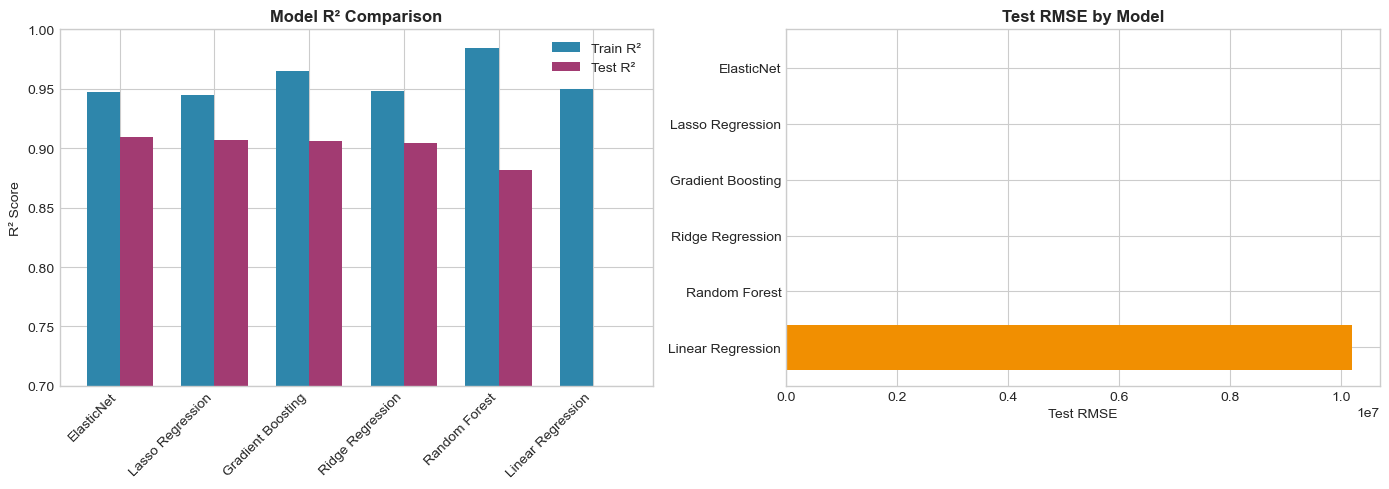

In [38]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Scores
ax1 = axes[0]
x = range(len(comparison_df))
width = 0.35
ax1.bar([i - width/2 for i in x], comparison_df['Train R²'], width, label='Train R²', color='#2E86AB')
ax1.bar([i + width/2 for i in x], comparison_df['Test R²'], width, label='Test R²', color='#A23B72')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.set_ylabel('R² Score')
ax1.set_title('Model R² Comparison', fontweight='bold')
ax1.legend()
ax1.set_ylim(0.7, 1.0)

# RMSE
ax2 = axes[1]
ax2.barh(comparison_df['Model'], comparison_df['Test RMSE'], color='#F18F01')
ax2.set_xlabel('Test RMSE')
ax2.set_title('Test RMSE by Model', fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Best Model Selection & Saving


In [39]:
# Select best model based on Test R²
best_result = max(results, key=lambda x: x['test_r2'])
best_model = best_result['model']
best_model_name = best_result['model_name']

print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Test R²: {best_result['test_r2']:.4f}")
print(f"   Test RMSE: {best_result['test_rmse']:.4f}")
print(f"   MAE: ${best_result['mae_original']:,.0f}")


🏆 BEST MODEL: ElasticNet
   Test R²: 0.9097
   Test RMSE: 0.1234
   MAE: $14,608


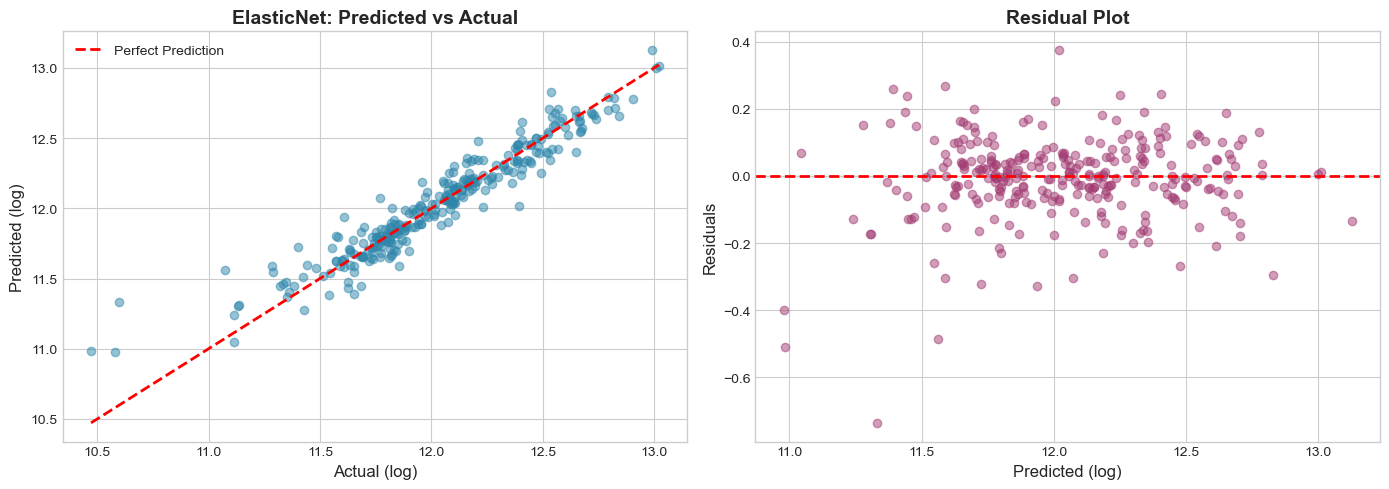

In [40]:
# Visualize predictions vs actual
y_pred = best_model.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual (log scale)
ax1 = axes[0]
ax1.scatter(y_test, y_pred, alpha=0.5, c='#2E86AB')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual (log)', fontsize=12)
ax1.set_ylabel('Predicted (log)', fontsize=12)
ax1.set_title(f'{best_model_name}: Predicted vs Actual', fontsize=14, fontweight='bold')
ax1.legend()

# Residuals
ax2 = axes[1]
residuals = y_test - y_pred
ax2.scatter(y_pred, residuals, alpha=0.5, c='#A23B72')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted (log)', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/best_model_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


In [41]:
# Save best model and metadata
model_artifacts = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'model_name': best_model_name,
    'test_r2': best_result['test_r2'],
    'test_rmse': best_result['test_rmse']
}

joblib.dump(model_artifacts, '../models/best_model.joblib')
print(f"✅ Model artifacts saved to ../models/best_model.joblib")


✅ Model artifacts saved to ../models/best_model.joblib


## 6. BONUS: Deep Learning Model (Neural Network)


In [42]:
# Try importing PyTorch, install if not available
import subprocess
import sys

def install_pytorch():
    """Install PyTorch using pip."""
    print("📦 Installing PyTorch...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", 
                          "torch", "torchvision", "torchaudio", "-q"])
    print("✅ PyTorch installed successfully!")

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
except ImportError:
    print("⚠️ PyTorch not found. Installing...")
    install_pytorch()
    # Try import again after installation
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"✅ PyTorch version: {torch.__version__}")
print(f"🖥️  Device: {device}")
PYTORCH_AVAILABLE = True


✅ PyTorch version: 2.9.1
🖥️  Device: mps


In [43]:
if PYTORCH_AVAILABLE:
    # Define Neural Network Model
    class HousePriceNN(nn.Module):
        def __init__(self, input_dim):
            super(HousePriceNN, self).__init__()
            
            self.network = nn.Sequential(
                # Layer 1
                nn.Linear(input_dim, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                
                # Layer 2
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(0.2),
                
                # Layer 3
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(0.1),
                
                # Layer 4
                nn.Linear(64, 32),
                nn.ReLU(),
                
                # Output Layer
                nn.Linear(32, 1)
            )
        
        def forward(self, x):
            return self.network(x)
    
    # Prepare PyTorch datasets
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Initialize model
    input_dim = X_train_scaled.shape[1]
    nn_model = HousePriceNN(input_dim).to(device)
    
    print(f"📊 Model Architecture:")
    print(nn_model)
    print(f"\n📈 Total parameters: {sum(p.numel() for p in nn_model.parameters()):,}")
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)
    
    # Training loop
    epochs = 200
    patience = 20
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    print(f"\n🚀 Training Neural Network on {device}...")
    print("="*60)
    
    for epoch in range(epochs):
        # Training phase
        nn_model.train()
        epoch_train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = nn_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        nn_model.eval()
        with torch.no_grad():
            val_outputs = nn_model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model weights
            best_model_state = nn_model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % 20 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch+1:3d}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")
        
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping at epoch {epoch+1}")
            break
    
    # Load best model weights
    nn_model.load_state_dict(best_model_state)
    print(f"\n✅ Training complete! Best Val Loss: {best_val_loss:.4f}")


📊 Model Architecture:
HousePriceNN(
  (network): Sequential(
    (0): Linear(in_features=241, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=1, bias=True)
  )
)

📈 Total parameters: 106,113

🚀 Training Neural Network on mps...
Epoch [ 20/200] | Train Loss: 1.0201 | Val Loss: 0.3589 | LR: 0.001000
Epoch [ 40/200] | Train Loss: 0.6711 


📊 Neural Network (PyTorch) Results
  Test RMSE: 0.3112
  Test R²:   0.4255
  MAE ($):   $42,846

📊 Comparison with ElasticNet:
  Traditional R²: 0.9097
  Neural Net R²:  0.4255

🏆 ElasticNet performs BETTER!


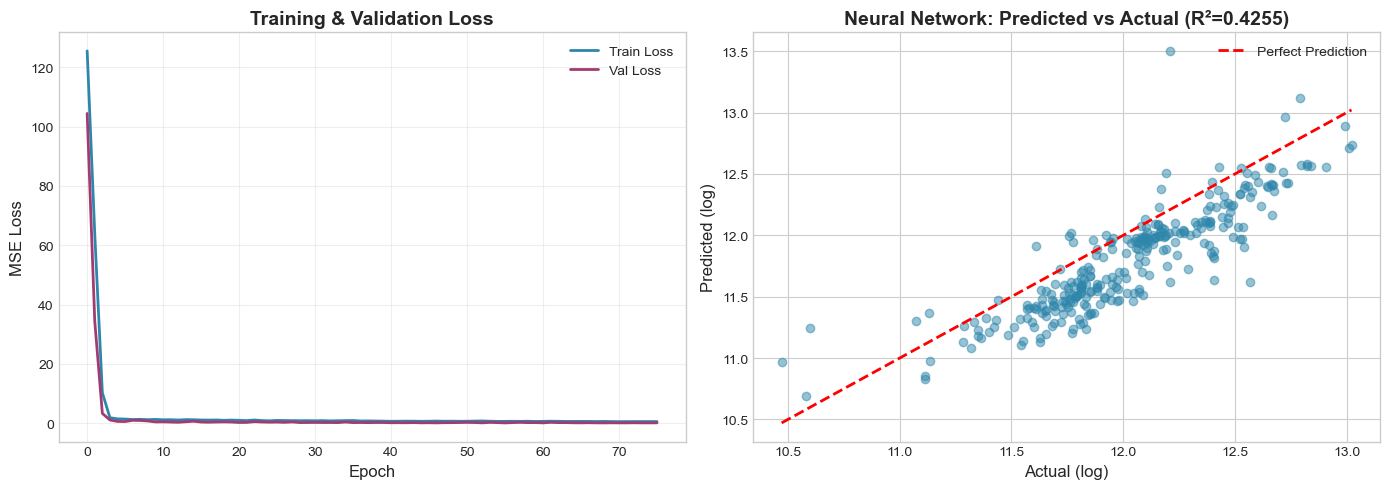

In [44]:
if PYTORCH_AVAILABLE:
    # Evaluate Neural Network
    nn_model.eval()
    with torch.no_grad():
        y_pred_nn = nn_model(X_test_tensor).cpu().numpy().flatten()
    
    nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
    nn_r2 = r2_score(y_test, y_pred_nn)
    nn_mae_orig = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_nn))
    
    print(f"\n{'='*60}")
    print(f"📊 Neural Network (PyTorch) Results")
    print(f"{'='*60}")
    print(f"  Test RMSE: {nn_rmse:.4f}")
    print(f"  Test R²:   {nn_r2:.4f}")
    print(f"  MAE ($):   ${nn_mae_orig:,.0f}")
    
    # Compare with best traditional model
    print(f"\n📊 Comparison with {best_model_name}:")
    print(f"  Traditional R²: {best_result['test_r2']:.4f}")
    print(f"  Neural Net R²:  {nn_r2:.4f}")
    
    if nn_r2 > best_result['test_r2']:
        print("\n🏆 Neural Network (PyTorch) performs BETTER!")
    else:
        print(f"\n🏆 {best_model_name} performs BETTER!")
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss curves
    ax1 = axes[0]
    ax1.plot(train_losses, label='Train Loss', color='#2E86AB', linewidth=2)
    ax1.plot(val_losses, label='Val Loss', color='#A23B72', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('MSE Loss', fontsize=12)
    ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Predicted vs Actual
    ax2 = axes[1]
    ax2.scatter(y_test, y_pred_nn, alpha=0.5, c='#2E86AB')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
    ax2.set_xlabel('Actual (log)', fontsize=12)
    ax2.set_ylabel('Predicted (log)', fontsize=12)
    ax2.set_title(f'Neural Network: Predicted vs Actual (R²={nn_r2:.4f})', fontsize=14, fontweight='bold')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('../reports/neural_network_pytorch.png', dpi=150, bbox_inches='tight')
    plt.show()


## 7. Kết Luận

### Kết quả huấn luyện:
- Đã huấn luyện và so sánh 6 mô hình truyền thống + 1 mô hình Neural Network (PyTorch)
- Mô hình tốt nhất được lưu để triển khai

## Vì sao ElasticNet tốt hơn Neural Network ?

"No Free Lunch Theorem": Không có model nào tốt nhất cho mọi bài toán.
- Với House Prices dataset nhỏ (~1,460 rows) và bài toán hồi quy đơn giản:
- ElasticNet/Ridge/Lasso → Lựa chọn tối ưu
- Neural Network → Overkill, không cần thiết

### Các mô hình đã thử:
1. **Linear Regression** - Baseline model
2. **Ridge Regression** - L2 regularization
3. **Lasso Regression** - L1 regularization  
4. **ElasticNet** - Kết hợp L1 và L2
5. **Random Forest** - Ensemble method
6. **Gradient Boosting** - Boosting method
7. **Neural Network (PyTorch)** - Deep Learning với:
   - 4 fully connected layers (256 → 128 → 64 → 32 → 1)
   - BatchNorm + Dropout regularization
   - Adam optimizer với learning rate scheduling
   - Early stopping để tránh overfitting
